#Prediksi Konsumsi Energi / jam

Created by: Muammar Khadafi

Dicoding username: muamkh

Jumlah data : 116189

MAE : 0.022341281211102782 / 2,23% (dari skala 0-1)

In [86]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import sklearn.preprocessing
from sklearn.metrics import r2_score, mean_absolute_error

from keras.layers import Dense,Dropout,SimpleRNN,LSTM
from keras.models import Sequential

In [87]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [88]:
import zipfile
zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Datasets/HourlyEnergyConsumption/HourlyEnergyConsumption.zip', 'r')
zip_ref.extractall('files')

In [89]:
df=pd.read_csv('/content/files/DOM_hourly.csv')
df.head()

,Datetime,DOM_MW
0,2005-12-31 01:00:00,9389.0
1,2005-12-31 02:00:00,9070.0
2,2005-12-31 03:00:00,9001.0
3,2005-12-31 04:00:00,9042.0
4,2005-12-31 05:00:00,9132.0


In [91]:
df = pd.read_csv('/content/files/DOM_hourly.csv', index_col='Datetime', parse_dates=['Datetime'])
df.head()

,DOM_MW
Datetime,
2005-12-31 01:00:00,9389.0
2005-12-31 02:00:00,9070.0
2005-12-31 03:00:00,9001.0
2005-12-31 04:00:00,9042.0
2005-12-31 05:00:00,9132.0


In [92]:
df.isna().sum()

DOM_MW    0
dtype: int64

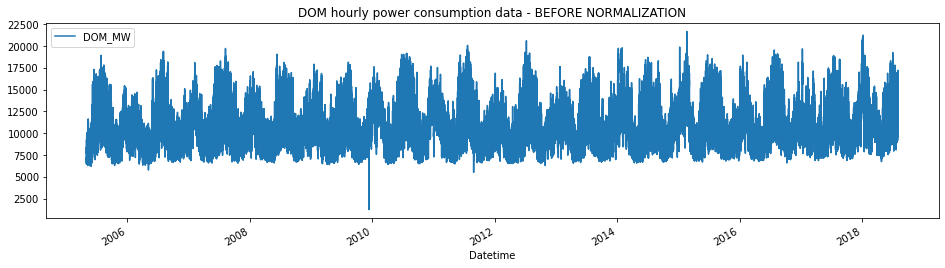

In [93]:
df.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - BEFORE NORMALIZATION')

plt.show()

In [94]:
def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['DOM_MW']=scaler.fit_transform(df['DOM_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(116189, 1)

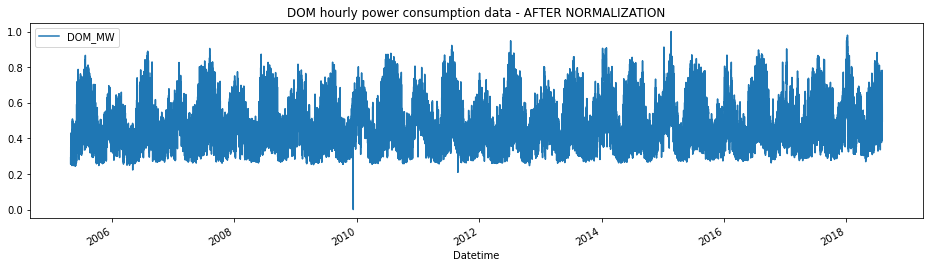

In [95]:
df_norm.plot(figsize=(16,4),legend=True)

plt.title('DOM hourly power consumption data - AFTER NORMALIZATION')

plt.show()

In [96]:
df_norm.shape

(116189, 1)

In [100]:
116189*25/100

29047.25

In [103]:
def load_data(stock, seq_len):
    X_train = []
    y_train = []
    for i in range(seq_len, len(stock)):
        X_train.append(stock.iloc[i-seq_len : i, 0])
        y_train.append(stock.iloc[i, 0])
    
    #1 last 29049 days are going to be used in validation
    X_val = X_train[87140:]             
    y_val = y_train[87140:]
    
    #2 first 87140 days are going to be used in training
    X_train = X_train[:87140]           
    y_train = y_train[:87140]
    
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    
    X_val = np.array(X_val)
    y_val = np.array(y_val)
    
    X_train = np.reshape(X_train, (87140, seq_len, 1))
    
    X_val = np.reshape(X_val, (X_val.shape[0], seq_len, 1))
    
    return [X_train, y_train, X_val, y_val]

In [104]:
seq_len = 20

X_train, y_train, X_val, y_val = load_data(df, seq_len)

print('X_train.shape = ',X_train.shape)
print('y_train.shape = ', y_train.shape)
print('X_val.shape = ', X_val.shape)
print('y_val.shape = ',y_val.shape)

X_train.shape =  (87140, 20, 1)
y_train.shape =  (87140,)
X_val.shape =  (29029, 20, 1)
y_val.shape =  (29029,)


In [105]:
class callBack(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('loss') <= 0.001):
            print()
            print("Training di stop karena loss sudah kurang dari 0.001")
            self.model.stop_training = True
callbacks = callBack()

In [106]:
lstm_model = Sequential()

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True, input_shape=(X_train.shape[1],1)))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=True))
lstm_model.add(Dropout(0.15))

lstm_model.add(LSTM(40,activation="tanh",return_sequences=False))
lstm_model.add(Dropout(0.15))

lstm_model.add(Dense(1))

lstm_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 20, 40)            6720      
_________________________________________________________________
dropout_15 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 20, 40)            12960     
_________________________________________________________________
dropout_16 (Dropout)         (None, 20, 40)            0         
_________________________________________________________________
lstm_17 (LSTM)               (None, 40)                12960     
_________________________________________________________________
dropout_17 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                

In [107]:
lstm_model.compile(loss=tf.keras.losses.Huber(),
              optimizer="adam",
              metrics=["mae"])
history = lstm_model.fit(X_train, y_train, epochs=10, batch_size=1000, callbacks=[callbacks])

Epoch 1/10
88/88 [==============================] - 29s 261ms/step - loss: 0.0246 - mae: 0.1656
Epoch 2/10
88/88 [==============================] - 23s 261ms/step - loss: 0.0062 - mae: 0.0866
Epoch 3/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0057 - mae: 0.0832
Epoch 4/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0040 - mae: 0.0707
Epoch 5/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0027 - mae: 0.0584
Epoch 6/10
88/88 [==============================] - 23s 259ms/step - loss: 0.0022 - mae: 0.0527
Epoch 7/10
88/88 [==============================] - 23s 258ms/step - loss: 0.0018 - mae: 0.0476
Epoch 8/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0015 - mae: 0.0427
Epoch 9/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0012 - mae: 0.0388
Epoch 10/10
88/88 [==============================] - 23s 260ms/step - loss: 0.0011 - mae: 0.0363


Text(0.5, 0, 'No. Of Epochs')

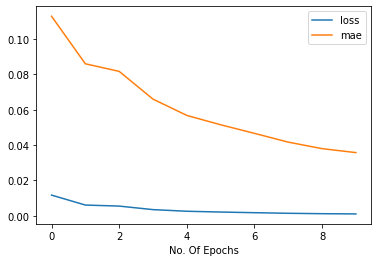

In [108]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["mae"],label="mae")
plt.legend(loc="best")
plt.xlabel("No. Of Epochs")

In [109]:
lstm_predictions = lstm_model.predict(X_val)

lstm_score = mean_absolute_error(y_val, lstm_predictions)
print("mean_absolute_error Score of LSTM model = ",lstm_score)

mean_absolute_error Score of LSTM model =  0.022341281211102782


In [110]:
def plot_predictions(val, predicted, title):
    plt.figure(figsize=(16,4))
    plt.plot(val, color='blue',label='Actual power consumption data')
    plt.plot(predicted, alpha=0.7, color='orange',label='Predicted power consumption data')
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Normalized power consumption scale')
    plt.legend()
    plt.show()

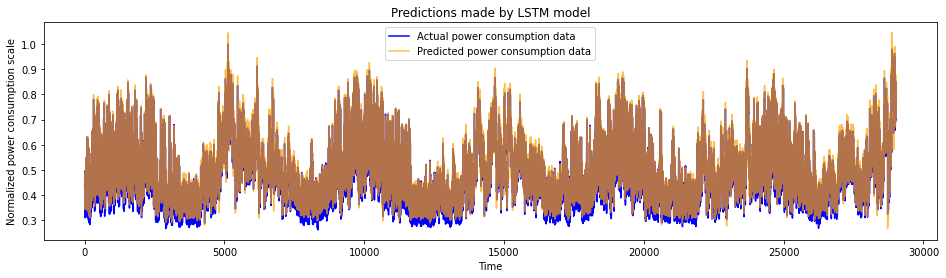

In [111]:
plot_predictions(y_val, lstm_predictions, "Predictions made by LSTM model")